# Imports

In [50]:
import kagglehub
import pandas as pd
import os
import seaborn as sns
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [51]:
path_congress = kagglehub.dataset_download(
    "shabbarank/congressional-trading-inception-to-march-23"
)

# Filtering 116th Congress Transactions

In [52]:
try:
    congress_df = pd.read_csv(
        os.path.join(path_congress, "copy of congress-trading-all (3).csv"),
        encoding="latin-1",
    )
except UnicodeDecodeError:
    try:
        congress_df = pd.read_csv(
            os.path.join(path_congress, "copy of congress-trading-all (3).csv"),
            encoding="cp1252",
        )
    except UnicodeDecodeError:
        congress_df = pd.read_csv(
            os.path.join(path_congress, "copy of congress-trading-all (3).csv"),
            encoding="iso-8859-1",
        )

stock_prices_df = pd.read_csv(
    os.path.join(path_congress, "stock_prices_2023_to_now.csv")
)

print("Congressional Trading Data Shape:", congress_df.shape)
print("Stock Prices Data Shape:", stock_prices_df.shape)

Congressional Trading Data Shape: (46467, 19)
Stock Prices Data Shape: (187126, 3)


In [78]:
# Convert the Traded column to datetime for filtering
congress_df["Traded_Date"] = pd.to_datetime(congress_df["Traded"])

# Filter for 116th Congress period (3 Jan 2019 to 3 Jan 2021)
congress_116_df = congress_df[
    (congress_df["Traded_Date"] >= "2020-01-03")
    & (congress_df["Traded_Date"] <= "2021-01-03")
]

# Filter to only purchases#
congress_116_df = congress_116_df[
    congress_116_df["Transaction"].str.contains("purchase", case=False, na=False)
]

print(f"Original dataset shape: {congress_df.shape}")
print(f"116th Congress period dataset shape: {congress_116_df.shape}")
print(
    f"Date range in filtered data: {congress_116_df['Traded_Date'].min()} to {congress_116_df['Traded_Date'].max()}"
)

Original dataset shape: (46467, 20)
116th Congress period dataset shape: (3824, 20)
Date range in filtered data: 2020-01-03 00:00:00 to 2020-12-31 00:00:00


# Statistics

In [79]:
# Count the number of unique politicians in the 116th Congress dataset
num_politicians = congress_116_df["Name"].nunique()
print(f"Number of politicians in 116th Congress dataset: {num_politicians}")

Number of politicians in 116th Congress dataset: 90


In [87]:
# Calculate average transaction count per politician
transaction_counts = congress_116_df.groupby("Name").size()
average_transactions = transaction_counts.mean()

print(f"Average transaction count per politician: {average_transactions:.2f}")
print(f"Total politicians: {len(transaction_counts)}")
print(f"Total transactions: {transaction_counts.sum()}")

Average transaction count per politician: 42.49
Total politicians: 90
Total transactions: 3824


## New Graph

In [93]:
# Limit to maximum 10 transactions per politician
df_limited = congress_116_df.groupby("Name").head(10).reset_index(drop=True)

print(f"Original dataset: {len(congress_116_df)} transactions")
print(f"Limited dataset: {len(df_limited)} transactions")
print(f"Politicians in limited dataset: {df_limited['Name'].nunique()}")

Original dataset: 3824 transactions
Limited dataset: 614 transactions
Politicians in limited dataset: 90


In [95]:
# Rewritten cell: build a bipartite-like graph with politician, transaction, and ticker nodes

import pandas as pd
import networkx as nx

# Create a new graph
G_politician_stocks = nx.Graph()

# Build nodes and edges: politician <-> transaction <-> ticker
for _, row in df_limited.iterrows():
    politician = row["Name"]
    ticker = row["Ticker"]
    traded_date = row["Traded_Date"]
    date_str = (
        traded_date.strftime("%d-%m-%Y") if pd.notna(traded_date) else "unknown-date"
    )

    # Transaction node id (unique per politician-ticker-date)
    tx_node = f"{politician}_{ticker}_{date_str}"

    # Add transaction node with attributes
    G_politician_stocks.add_node(
        tx_node,
        type="transaction",
        politician=politician,
        ticker=ticker,
        date=traded_date,
        transaction=row.get("Transaction")
        if isinstance(row, dict)
        else row["Transaction"],
    )

    # Ensure politician node exists and has type attribute
    if politician not in G_politician_stocks:
        G_politician_stocks.add_node(politician, type="politician", name=politician)
    else:
        if "type" not in G_politician_stocks.nodes[politician]:
            G_politician_stocks.nodes[politician]["type"] = "politician"

    # Ensure ticker node exists and has type attribute (skip missing tickers)
    if pd.notna(ticker):
        if ticker not in G_politician_stocks:
            G_politician_stocks.add_node(ticker, type="ticker", ticker=ticker)
        else:
            if "type" not in G_politician_stocks.nodes[ticker]:
                G_politician_stocks.nodes[ticker]["type"] = "ticker"

    # Connect politician -> transaction -> ticker
    G_politician_stocks.add_edge(politician, tx_node)
    if pd.notna(ticker):
        G_politician_stocks.add_edge(tx_node, ticker)

# Summary
print(f"Created graph with {G_politician_stocks.number_of_nodes()} nodes")
print(f"Number of edges: {G_politician_stocks.number_of_edges()}")

Created graph with 1003 nodes
Number of edges: 1170


In [96]:
# ...existing code...

# Add edges between transactions of the same ticker with date difference <= 10 days
from collections import defaultdict
import pandas as pd

# Group transaction nodes by ticker
transactions_by_ticker = defaultdict(list)
for node, attrs in G_politician_stocks.nodes(data=True):
    if attrs.get("type") == "transaction":
        ticker = attrs["ticker"]
        date = attrs["date"]
        if pd.notna(date):
            transactions_by_ticker[ticker].append((node, date))

# For each ticker, sort transactions by date and add edges for close dates
for ticker, tx_list in transactions_by_ticker.items():
    if len(tx_list) > 1:
        # Sort by date
        tx_list.sort(key=lambda x: x[1])
        # Add edges between transactions within 10 days
        for i in range(len(tx_list)):
            for j in range(i + 1, len(tx_list)):
                date1 = tx_list[i][1]
                date2 = tx_list[j][1]
                if (date2 - date1).days <= 10:
                    G_politician_stocks.add_edge(tx_list[i][0], tx_list[j][0])
                else:
                    # Since sorted, no need to check further for this i
                    break

print(f"After adding intra-ticker edges: {G_politician_stocks.number_of_edges()} edges")
# ...existing code...

After adding intra-ticker edges: 1262 edges


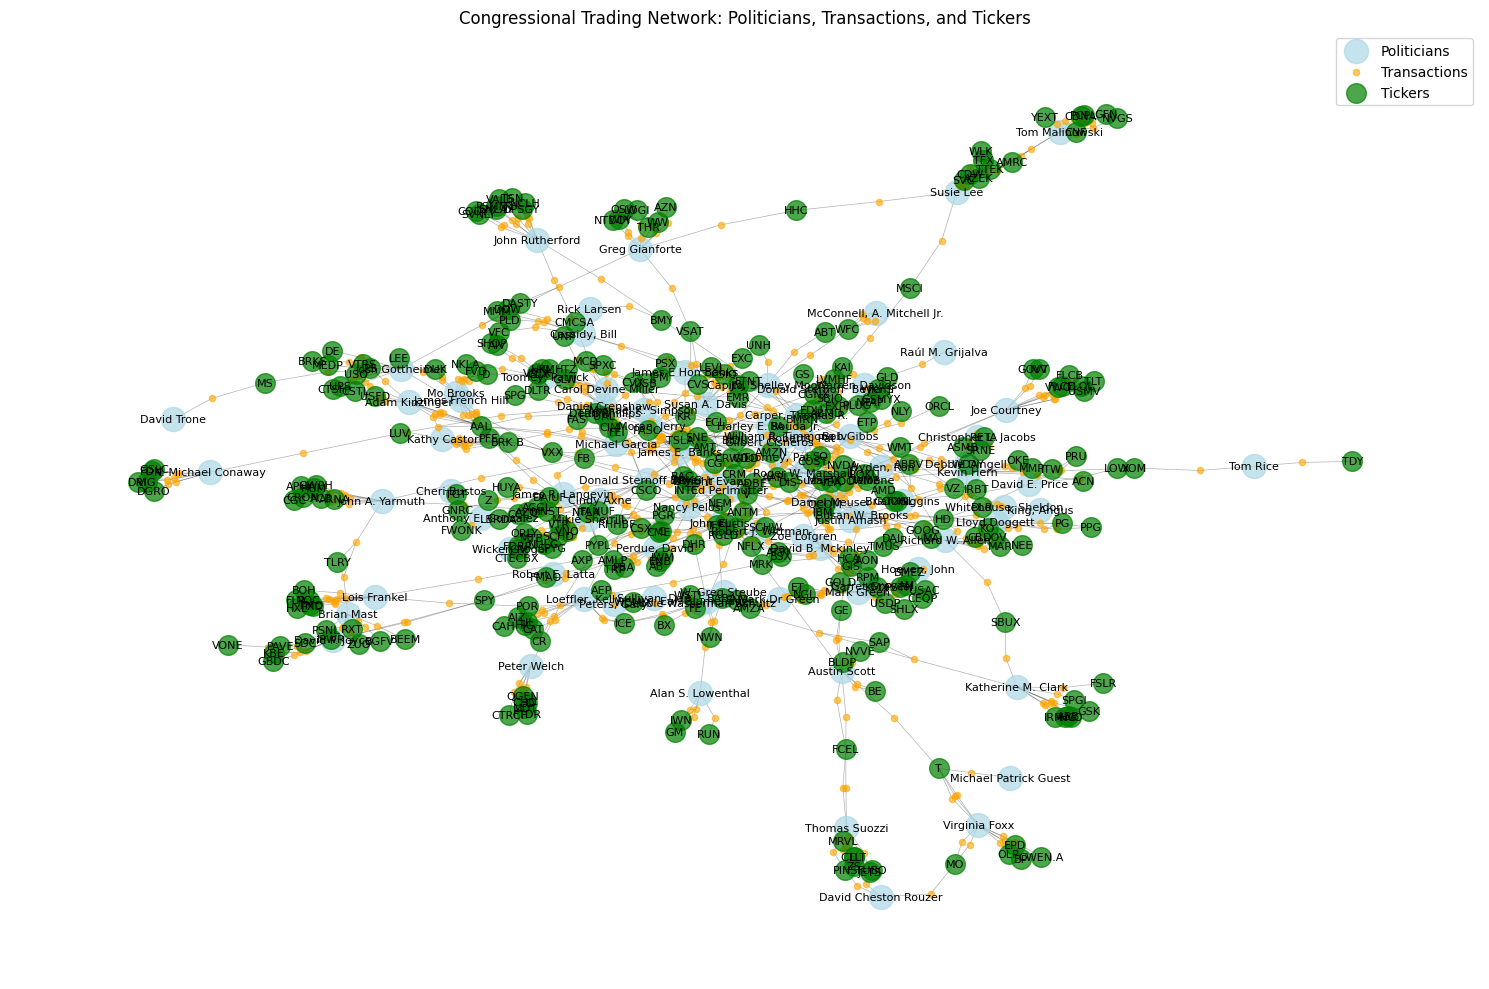

Graph visualization complete:
Politicians: 90
Transactions: 585
Tickers: 328

Graph Complexity Analysis:
Total nodes: 1003
Total edges: 1262
Graph density: 0.002511


In [97]:
# Plot the politician-stock graph with politicians, transactions, and tickers
plt.figure(figsize=(15, 10))

# Get nodes by type
politician_nodes = [
    n
    for n, attr in G_politician_stocks.nodes(data=True)
    if attr.get("type") == "politician"
]
transaction_nodes = [
    n
    for n, attr in G_politician_stocks.nodes(data=True)
    if attr.get("type") == "transaction"
]
ticker_nodes = [
    n
    for n, attr in G_politician_stocks.nodes(data=True)
    if attr.get("type") == "ticker"
]

# Create layout
pos = nx.spring_layout(G_politician_stocks, k=1, iterations=50)

# Draw politician nodes
nx.draw_networkx_nodes(
    G_politician_stocks,
    pos,
    nodelist=politician_nodes,
    node_color="lightblue",
    node_size=300,
    alpha=0.7,
    label="Politicians",
)

# Draw transaction nodes
nx.draw_networkx_nodes(
    G_politician_stocks,
    pos,
    nodelist=transaction_nodes,
    node_color="orange",
    node_size=20,
    alpha=0.6,
    label="Transactions",
)

# Draw ticker nodes
nx.draw_networkx_nodes(
    G_politician_stocks,
    pos,
    nodelist=ticker_nodes,
    node_color="green",
    node_size=200,
    alpha=0.7,
    label="Tickers",
)

# Draw edges
nx.draw_networkx_edges(G_politician_stocks, pos, alpha=0.3, width=0.5)

# Draw labels for politicians and tickers (transaction labels would be too cluttered)
politician_labels = {n: n for n in politician_nodes}
ticker_labels = {n: n for n in ticker_nodes}
nx.draw_networkx_labels(
    G_politician_stocks, pos, labels={**politician_labels, **ticker_labels}, font_size=8
)

plt.title("Congressional Trading Network: Politicians, Transactions, and Tickers")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Graph visualization complete:")
print(f"Politicians: {len(politician_nodes)}")
print(f"Transactions: {len(transaction_nodes)}")
print(f"Tickers: {len(ticker_nodes)}")
# Display graph statistics and suggestions for faster plotting
print("\nGraph Complexity Analysis:")
print(f"Total nodes: {G_politician_stocks.number_of_nodes()}")
print(f"Total edges: {G_politician_stocks.number_of_edges()}")
print(f"Graph density: {nx.density(G_politician_stocks):.6f}")

# Creating Base Graph

We want to find all pairs of congressmen that purchased the same stock at an interval of 10 days

In [46]:
NAME_COL = "Name"
TICKER_COL = "Ticker"
DATE_COL = "Traded_Date"
TYPE_COL = "Transaction"

df = congress_116_df.copy()

# normalize types
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[NAME_COL, TICKER_COL, DATE_COL])

# keep only purchases
df = df[df[TYPE_COL].str.contains("purchase", case=False, na=False)]

# prepare for self-join
left = df[[NAME_COL, TICKER_COL, DATE_COL]].rename(
    columns={NAME_COL: "name_1", DATE_COL: "date_1"}
)
right = df[[NAME_COL, TICKER_COL, DATE_COL]].rename(
    columns={NAME_COL: "name_2", DATE_COL: "date_2"}
)

pairs = left.merge(right, on=TICKER_COL)
pairs = pairs[pairs["name_1"] != pairs["name_2"]]

# keep pairs within 20 days
pairs["diff_days"] = (pairs["date_1"] - pairs["date_2"]).abs().dt.days
pairs = pairs[pairs["diff_days"] <= 10]

# order so congressman_1 = earlier buyer, congressman_2 = later buyer
is_earlier = pairs["date_1"] < pairs["date_2"]
congressman_1 = np.where(is_earlier, pairs["name_1"], pairs["name_2"])
congressman_2 = np.where(is_earlier, pairs["name_2"], pairs["name_1"])
date_earlier = np.where(is_earlier, pairs["date_1"], pairs["date_2"])
date_later = np.where(is_earlier, pairs["date_2"], pairs["date_1"])

out = pd.DataFrame(
    {
        "congressman_1": congressman_1,  # earlier buyer
        "congressman_2": congressman_2,  # later buyer
        "stock": pairs[TICKER_COL],
        "transaction_date_1": date_later,  # later date (matches your example)
        "transaction_date_2": date_earlier,  # earlier date
    }
)

# remove duplicate unordered pairs (one row per pair + ticker)
out = out.drop_duplicates(
    subset=["congressman_1", "congressman_2", "stock"]
).reset_index(drop=True)

out

,congressman_1,congressman_2,stock,transaction_date_1,transaction_date_2
0,"Roberts, Pat",Gilbert Cisneros,NVDA,2020-12-31,2020-12-21
1,"Roberts, Pat",Gilbert Cisneros,COST,2020-12-31,2020-12-22
2,Nancy Pelosi,"Carper, Thomas R.",TSLA,2020-12-30,2020-12-22
3,Gilbert Cisneros,"Carper, Thomas R.",TSLA,2020-12-30,2020-12-22
4,Susie Lee,Tom Malinowski,AMRC,2020-12-29,2020-12-29
...,...,...,...,...,...
683,"Roberts, Pat",Donald Sternoff Beyer Jr,AMZN,2020-01-10,2020-01-10
684,Thomas Suozzi,Donald Sternoff Beyer Jr,MSFT,2020-01-09,2020-01-09
685,Dean Phillips,Lois Frankel,CB,2020-01-09,2020-01-07
686,Donald Sternoff Beyer Jr,Thomas Suozzi,MSFT,2020-01-09,2020-01-09


Creating bipartite graph between congressmen and mutual stock purchases.

For example, If Alice and Bob purchased TSLA stock at 2020-12-21 and 2020-12-11 (10 days difference) 
then they will be connected to a node named `TSLA_2020-12-21_2020-12-11`

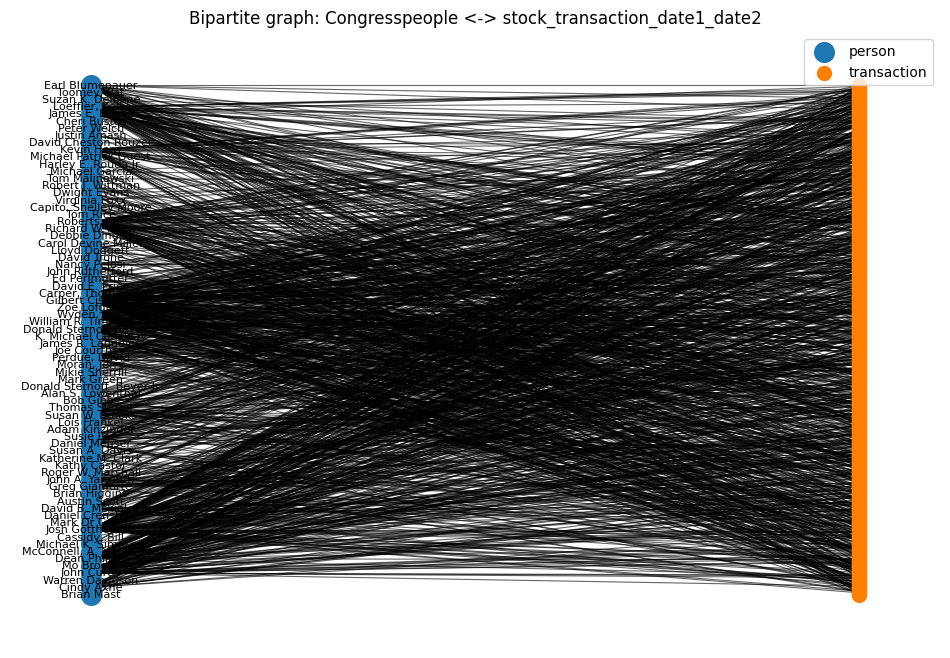

In [47]:
out["td1_str"] = pd.to_datetime(out["transaction_date_1"]).dt.strftime("%Y-%m-%d")
out["td2_str"] = pd.to_datetime(out["transaction_date_2"]).dt.strftime("%Y-%m-%d")

# create transaction node id: STOCK_transactionDate1_transactionDate2
out["txn_node"] = out["stock"].astype(str) + "_" + out["td1_str"] + "_" + out["td2_str"]

G = nx.Graph()

# add person nodes (bipartite 0)
persons = sorted(set(out["congressman_1"]).union(out["congressman_2"]))
G.add_nodes_from(persons, bipartite=0, node_type="person")

# add transaction nodes (bipartite 1)
txns = out["txn_node"].unique().tolist()
G.add_nodes_from(txns, bipartite=1, node_type="transaction")

# add edges: connect both congressman_1 and congressman_2 to the transaction node for each row
for _, row in out.iterrows():
    G.add_edge(row["congressman_1"], row["txn_node"])
    G.add_edge(row["congressman_2"], row["txn_node"])

# optional: draw a bipartite layout (persons on left, transactions on right)
pos = nx.bipartite_layout(G, persons)

plt.figure(figsize=(12, 8))
person_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "person"]
txn_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "transaction"]

nx.draw_networkx_nodes(
    G, pos, nodelist=person_nodes, node_color="#1f78b4", node_size=200, label="person"
)
nx.draw_networkx_nodes(
    G, pos, nodelist=txn_nodes, node_color="#ff7f00", node_size=100, label="transaction"
)
nx.draw_networkx_edges(G, pos, alpha=0.6, width=0.8)
nx.draw_networkx_labels(
    G, pos, labels={n: n if n in person_nodes else "" for n in G.nodes()}, font_size=8
)

plt.axis("off")
plt.legend(scatterpoints=1)
plt.title("Bipartite graph: Congresspeople <-> stock_transaction_date1_date2")
plt.show()
# ...existing code...